## Simulação e forecasting de indicadores financeiros da Petrobras
##### 30/04/2022 - Lucas Amaral

#### Motivação:

* Simular, otimizar e realizar previsões de indicadores financeiros a partir do Demonstrativo de Resultados do Exercício da empresa Petrobras.
  * O DRE indica se a empresa está gerando lucro ou prejuízo;
  * Os indicadores presentes neste relatório são fórmulas matemáticas:
  * Lucro líquido = Receitas - Custos - Despesas Operacionais - Despesas Financeiras - Impostos
* Simular o que o gestor precisa fazer para aumentar em 25% o lucro líquido da empresa;
* Validar se a resposta é viável de acordo com o histórico da empresa.

#### Exemplo de DRE

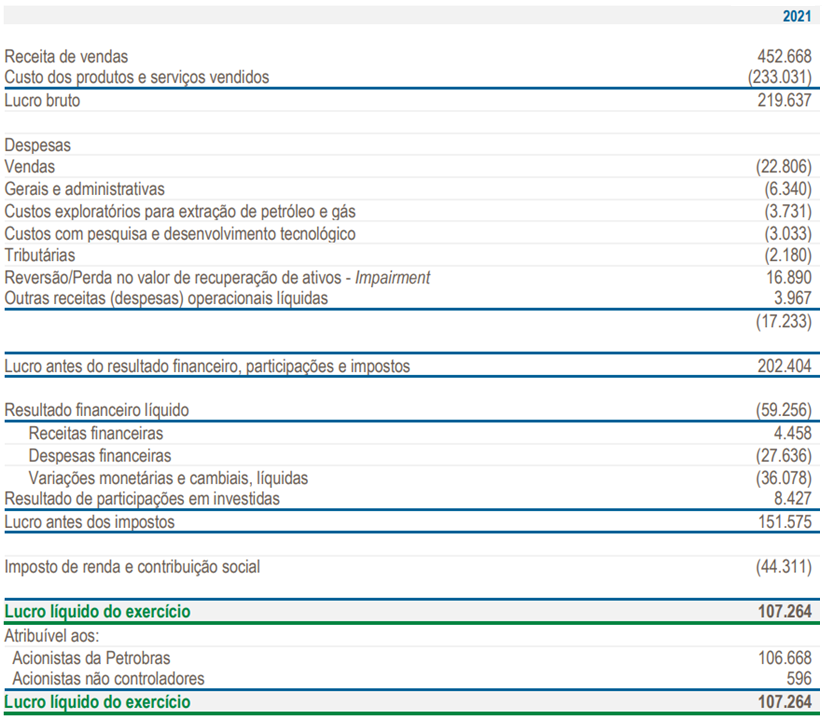

### Imports

In [77]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from scipy.optimize import minimize
from tabulate import tabulate
import warnings
import itertools
warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 100

### Dados da Petrobras

* Scrapy do site InvestSite (https://www.investsite.com.br/demonstracao_resultado.php?cod_negociacao=PETR4)
* DREs trimestrais desde 2002
  * 80 linhas de informação
* DREs em formatos diferentes:
  * 2002 -> 2010
  * 2011 -> 2021

In [78]:
# Conectar com o google drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [79]:
# Leitura do Dataset

df = pd.read_csv('drive/MyDrive/Artigo Pós/Datasets/petrobras_investsite_unificado_2.csv', sep=";")
df['date'] = df.year.astype(str) + "-Q" + df.quarter.astype(str).apply(lambda x : x[:-1])
df = df[df.year > 2001]
df.date = pd.date_range('2002', periods=len(df), freq="Q-DEC")
df = df.set_index("date")
df = df.sort_values('date')
df = df.fillna(0)

df['receitas'] = df['receitas'] / 1000000
df['custos'] = df['custos'] / 1000000
df['resultado_bruto'] = df['resultado_bruto'] / 1000000
df['despesas_receitas_operacionais'] = df['despesas_receitas_operacionais'] / 1000000
df['resultado_operacional'] = df['resultado_operacional'] / 1000000
df['resultado_financeiro'] = df['resultado_financeiro'] / 1000000
df['resultado_antes_impostos'] = df['resultado_antes_impostos'] / 1000000
df['impostos'] = df['impostos'] / 1000000
df['resultado_liquido_continuadas'] = df['resultado_liquido_continuadas'] / 1000000
df['resultado_liquido_descontinuadas'] = df['resultado_liquido_descontinuadas'] / 1000000
df['participacoes_outras_empresas'] = df['participacoes_outras_empresas'] / 1000000
df['lucro_periodo'] = df['lucro_periodo'] / 1000000
df

,year,quarter,receitas,custos,resultado_bruto,despesas_receitas_operacionais,resultado_operacional,resultado_financeiro,resultado_antes_impostos,impostos,resultado_liquido_continuadas,resultado_liquido_descontinuadas,participacoes_outras_empresas,lucro_periodo
date,,,,,,,,,,,,,,
2002-03-31,2002,1T,11.238837,-7.536662,3.702175,-2.024293,1.677882,0.007736,1.685618,-0.714523,0.971095,0.0,-0.105583,0.865512
2002-06-30,2002,2T,15.798535,-9.498289,6.300246,-3.129495,3.170751,-0.008290,3.162461,-1.510129,1.652332,0.0,0.383314,2.035646
2002-09-30,2002,3T,21.295891,-13.770499,7.525392,-5.153905,2.371487,-0.108543,2.262944,-0.748069,1.514875,0.0,0.852700,2.367575
2002-12-31,2002,4T,20.842892,-13.399800,7.443092,-2.593021,4.850071,-0.061004,4.789067,-1.036063,3.753004,0.0,-0.923946,2.829058
2003-03-31,2003,1T,24.499978,-12.479571,12.020407,-2.899048,9.121359,-0.056197,9.065162,-3.314155,5.751007,0.0,-0.206197,5.544810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,2020,4T,74.972000,-34.612000,40.360000,27.649000,68.009000,6.812000,74.821000,-14.369000,60.452000,0.0,0.000000,60.452000
2021-03-31,2021,1T,86.174000,-42.141000,44.033000,-10.129000,33.904000,-30.748000,3.156000,-1.880000,1.276000,0.0,0.000000,1.276000
2021-06-30,2021,2T,110.710000,-53.705000,57.005000,-4.824000,52.181000,10.776000,62.957000,-19.916000,43.041000,0.0,0.000000,43.041000


### Funções úteis

In [80]:
# Função para medir MAE, MSE e RMSE

from sklearn.metrics import mean_absolute_error, mean_squared_error

def mae_mse_rmse(y, y_pred):
    mae = round(mean_absolute_error(y, y_pred),4)
    mse = round(mean_squared_error(y, y_pred),4)
    rmse = round(np.sqrt(mse),4)
    return mae, mse, rmse

## Análise exploratória

In [81]:
# Informações sobre o dataset

df.describe()

,year,receitas,custos,resultado_bruto,despesas_receitas_operacionais,resultado_operacional,resultado_financeiro,resultado_antes_impostos,impostos,resultado_liquido_continuadas,resultado_liquido_descontinuadas,participacoes_outras_empresas,lucro_periodo
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,2011.500000,59.776122,-38.567341,21.208781,-10.536870,10.671910,-3.302245,7.369665,-2.302156,5.067509,0.126600,-0.178228,5.015881
std,5.802662,24.745694,17.013178,10.450552,13.566945,16.450495,6.580070,17.205915,4.522249,12.971399,1.046031,0.470136,12.951865
min,2002.000000,11.238837,-75.143000,3.702175,-77.055000,-45.440000,-30.748000,-66.618000,-19.916000,-49.724000,0.000000,-1.876852,-49.724000
25%,2006.750000,41.608521,-52.217037,16.283535,-11.292453,7.045422,-6.051250,4.553371,-3.355894,2.483083,0.000000,-0.310076,2.811793
50%,2011.500000,65.156525,-39.194646,19.162700,-7.986876,9.491186,-0.177509,7.783454,-2.369510,5.752635,0.000000,0.000000,5.424907
75%,2016.250000,75.096250,-24.597945,23.441500,-5.438561,12.363314,0.000000,11.093810,-1.195824,7.806439,0.000000,0.000000,7.742619
max,2021.000000,134.190000,-7.536662,59.552000,27.649000,68.009000,10.776000,74.821000,16.894000,60.452000,9.349000,0.960665,60.452000


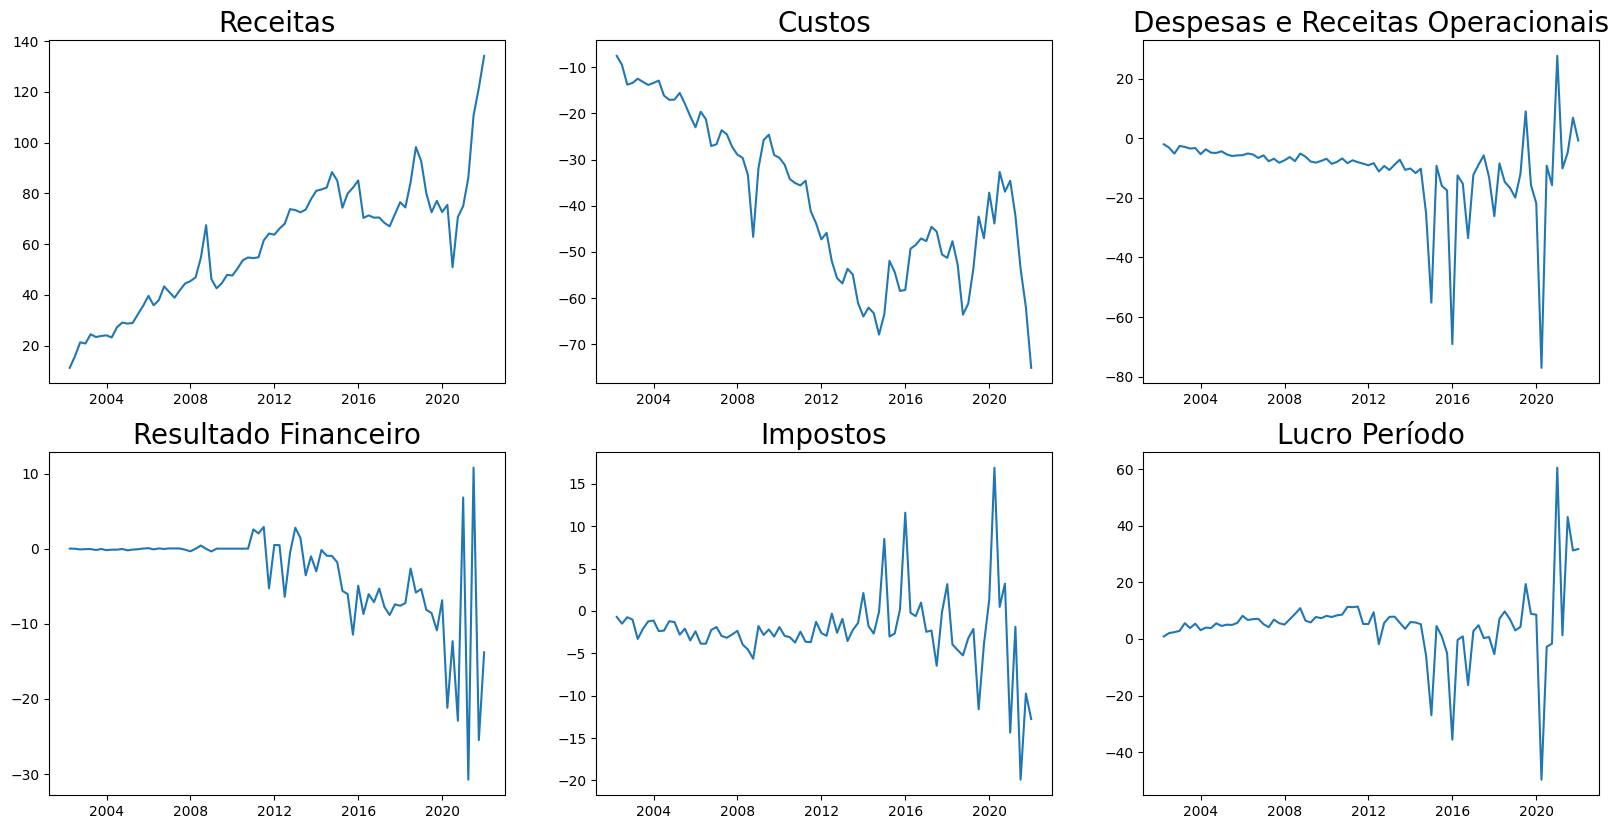

In [82]:
# Plot das linhas do DRE

figure, axis = plt.subplots(2, 3, figsize=(20,10))

# Linha 1

axis[0, 0].plot(df.index, df.receitas)
axis[0, 0].set_title("Receitas",fontsize=20)

axis[0, 1].plot(df.index, df.custos)
axis[0, 1].set_title("Custos",fontsize=20)

axis[0, 2].plot(df.index, df.despesas_receitas_operacionais)
axis[0, 2].set_title("Despesas e Receitas Operacionais",fontsize=20)

# Linha 2

axis[1, 0].plot(df.index, df.resultado_financeiro)
axis[1, 0].set_title("Resultado Financeiro",fontsize=20)

axis[1, 1].plot(df.index, df.impostos)
axis[1, 1].set_title("Impostos",fontsize=20)

axis[1, 2].plot(df.index, df.lucro_periodo)
axis[1, 2].set_title("Lucro Período",fontsize=20)


plt.show()

In [83]:
# Teste adFuller, verificar se a serie é non-stationary. 
# Séries não estacionárias são mais complexas para o modelo ficar assertivo.

# Caso o P-value for maior que 0.05, então a serie é não estacionária

from statsmodels.tsa.stattools import adfuller

columns  = ['receitas','custos','despesas_receitas_operacionais','resultado_financeiro','impostos','lucro_periodo']

for col in columns:
    result = adfuller(df[col].dropna())
    print(f'{col}: p-value: {result[1]}')

receitas: p-value: 0.6552715811019719
custos: p-value: 0.6013172057728801
despesas_receitas_operacionais: p-value: 0.04540797682595297
resultado_financeiro: p-value: 0.9964468269657164
impostos: p-value: 0.28805520869236295
lucro_periodo: p-value: 0.19545439247638274


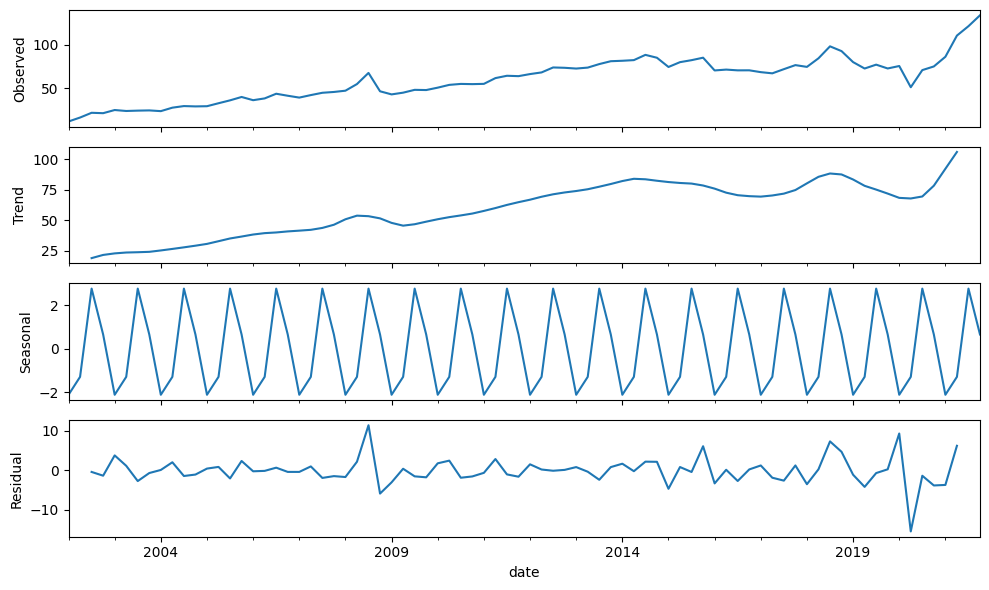

In [84]:
# Decomposição da serie: Trend, Seasonality, Noise

from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 10, 6

# Receitas

decomposition = sm.tsa.seasonal_decompose(df.receitas, model='additive')
fig = decomposition.plot()
plt.show()

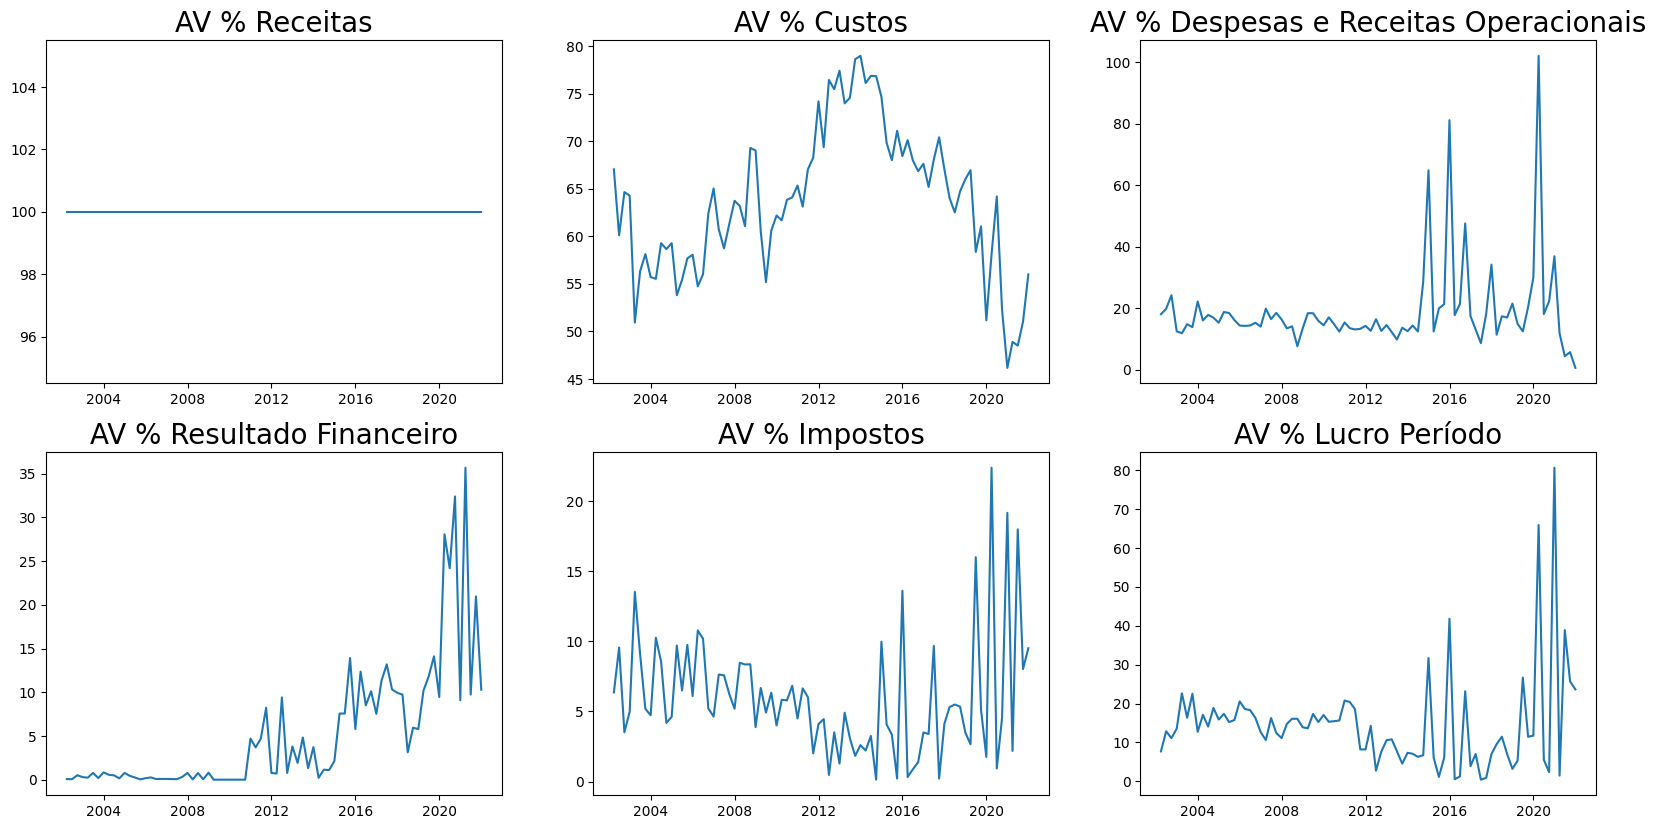

In [85]:
# Analise vertical

figure, axis = plt.subplots(2, 3, figsize=(20, 10))

# Linha 1

axis[0, 0].plot(df.index, df.receitas / df.receitas * 100)
axis[0, 0].set_title("AV % Receitas",fontsize=20)

av_custos = abs(df.custos / df.receitas * 100)

axis[0, 1].plot(df.index, av_custos)
axis[0, 1].set_title("AV % Custos",fontsize=20)

av_despesas = abs(df.despesas_receitas_operacionais / df.receitas * 100)

axis[0, 2].plot(df.index, av_despesas)
axis[0, 2].set_title("AV % Despesas e Receitas Operacionais",fontsize=20)

# Linha 2

av_financeiro = abs(df.resultado_financeiro / df.receitas * 100)

axis[1, 0].plot(df.index, av_financeiro)
axis[1, 0].set_title("AV % Resultado Financeiro",fontsize=20)

av_impostos = abs(df.impostos / df.receitas * 100)

axis[1, 1].plot(df.index, av_impostos)
axis[1, 1].set_title("AV % Impostos",fontsize=20)

av_lucro = abs(df.lucro_periodo / df.receitas * 100)

axis[1, 2].plot(df.index, av_lucro)
axis[1, 2].set_title("AV % Lucro Período",fontsize=20)

plt.show()

## Simulador e otimizador de valores

#### Criar Funções para obter o lucro líquido

In [86]:
# Funções para calcular lucro líquido

def lucro_liq(x):
    xObj = get_obj(x)
    return lucro_liq_continuadas(xObj) + xObj['resultado_liquido_descontinuadas'] + xObj['participacoes_outras_empresas']

def lucro_liq_continuadas(x):
    return lucro_antes_impostos(x) + x['impostos']

def lucro_antes_impostos(x):
    return lucro_antes_res_fin(x) + result_fin(x)

def lucro_antes_res_fin(x):
    return lucro_bruto(x) + despesas(x)

def result_fin(x):
    return x['resultado_financeiro']

def lucro_bruto(x):
    return x['receitas'] + x['custos']

def despesas(x):
    return x['despesas_receitas_operacionais']

def get_obj(x):
    xObj = {}
    xObj['receitas'] = x[0]
    xObj['custos'] = x[1]
    xObj['despesas_receitas_operacionais'] = x[2]
    xObj['resultado_financeiro'] = x[3]
    xObj['impostos'] = x[4]
    xObj['resultado_liquido_descontinuadas'] = x[5]
    xObj['participacoes_outras_empresas'] = x[6]
    return xObj

#### Validar se a função funciona

In [87]:
# Função para validar se os métodos estão calculando o lucro líquido corretamente

def match_fn_lucro_liq(x0, df):
    fun_result = lucro_liq(x0)
    dataset_result = df['lucro_periodo'].sum()
    is_equal = fun_result == dataset_result
    year_quarter = df.index
    return year_quarter, fun_result, dataset_result, is_equal

In [88]:
# Teste da função lucro líquido

failed = []

for idx in df.index:
    df_simul = df[df.index == idx]
    n = 7
    x0 = np.zeros(n)
    x0[0] = df_simul['receitas'].sum()
    x0[1] = df_simul['custos'].sum()
    x0[2] = df_simul['despesas_receitas_operacionais'].sum()
    x0[3] = df_simul['resultado_financeiro'].sum()
    x0[4] = df_simul['impostos'].sum()
    x0[5] = df_simul['resultado_liquido_descontinuadas'].sum()
    x0[6] = df_simul['participacoes_outras_empresas'].sum()
    year_quarter, fun_result, dataset_result, is_equal = match_fn_lucro_liq(x0, df_simul)
    if is_equal is False:
        print("Função do lucro líquido falhou para o trimestre: ", year_quarter)
        failed.append(year_quarter)

if len(failed) == 0:
    print("Todas linhas passaram")

Todas linhas passaram


#### Função de otimização

In [89]:
# Funções para definir o valor objetivo

def goal_restriction(goal):
    def inner_goal_restriction(x):
        return lucro_liq(x) - goal

    return inner_goal_restriction

# Funções para definir limites das variáveis

def get_bound(value, tx=.5):
    min = 1 - tx
    max = 1 + tx
    return (value * min, value * max) if value > 0 else (value * max, value * min)

# Função para executar a otimização

def optimize(x0, goal):
    b0 = get_bound(x0[0], .4) # receitas
    b1 = get_bound(x0[1], .4) # custos
    b2 = get_bound(x0[2], .2) # despesas_receitas_operacionais
    b3 = get_bound(x0[3], .3) # resultado_financeiro
    b4 = get_bound(x0[4], .3) # impostos
    b5 = get_bound(x0[5], .2) # resultado_liquido_descontinuadas
    b6 = get_bound(x0[6], .1) # participacoes_outras_empresas

    bnds = (b0 ,b1 ,b2 ,b3 ,b4 ,b5, b6)

    con1 = {'type': 'eq', 'fun': goal_restriction(goal)} 
    cons = ([con1])

    solution = minimize(lucro_liq,
                        x0,
                        method='SLSQP',
                        bounds=bnds,
                        constraints=cons
                        )
    return solution

#### Teste de otimização

In [90]:
# Função auxiliar para calcular percentuais
def perc(a, b):
    return abs(round(a / b * 100, 0))

# Dados base para otimizar
year_quarter_simul = '2021-Q4'
df_simulacao = df[year_quarter_simul]

# Definir parametros
n = 7
x0 = np.zeros(n)
x0[0] = df_simulacao['receitas'].sum()
x0[1] = df_simulacao['custos'].sum()
x0[2] = df_simulacao['despesas_receitas_operacionais'].sum()
x0[3] = df_simulacao['resultado_financeiro'].sum()
x0[4] = df_simulacao['impostos'].sum()
x0[5] = df_simulacao['resultado_liquido_descontinuadas'].sum()
x0[6] = df_simulacao['participacoes_outras_empresas'].sum()

# Objetivo: Aumentar em 25% o Lucro Líquido
x0_lucro_liq = lucro_liq(x0)
goal = lucro_liq(x0) * 1.25

# Executar a otimização
solution = optimize(x0, goal)

# Valor objetivo encontrado
solution_res = solution.fun 

# Parametros usados para encontrar o valor objetivo
params = solution.x

print("Goal                       : ", goal)
print("Otimização alcançou o valor: ", solution_res)
print("Número de simulações       : ", solution.nit)
print("")

result_table = [
    ['receitas',                             params[0],    perc(params[0], params[0]),    x0[0],        perc(x0[0], x0[0]),        perc(params[0], x0[0])],
    ['custos',                               params[1],    perc(params[1], params[0]),    x0[1],        perc(x0[1], x0[0]),        perc(params[1], x0[1])],
    ['despesas_receitas_operacionais',       params[2],    perc(params[2], params[0]),    x0[2],        perc(x0[2], x0[0]),        perc(params[2], x0[2])],
    ['resultado_financeiro',                 params[3],    perc(params[3], params[0]),    x0[3],        perc(x0[3], x0[0]),        perc(params[3], x0[3])],
    ['impostos',                             params[4],    perc(params[4], params[0]),    x0[4],        perc(x0[4], x0[0]),        perc(params[4], x0[4])],
    ['resultado_liquido_descontinuadas',     params[5],    perc(params[5], params[0]),    x0[5],        perc(x0[5], x0[0]),        perc(params[5], x0[5])],
    ['participacoes_outras_empresas',        params[6],    perc(params[6], params[0]),    x0[6],        perc(x0[6], x0[0]),        perc(params[6], x0[6])],
    ['Lucro líquido',                        solution_res, perc(solution_res, params[0]), x0_lucro_liq, perc(solution_res, x0[0]), perc(solution_res, x0_lucro_liq)]
]

print(tabulate(result_table, headers=['Linha DRE', 'Valor Otimizado', "% A.V*", "Valor Inicial", "% A.V*", "% (Otimizado / Inicial)"]))
print("")
print("*Análise vertical => Essa análise acontece de cima para baixo ou de baixo para cima, indicando resultados em efeito cascata, ele é utilizado para identificar a porcentagem de participação de determinado indicador no resultados. ")

Goal                       :  39.65374999999999
Otimização alcançou o valor:  39.65374999999998
Número de simulações       :  2

Linha DRE                           Valor Otimizado    % A.V*    Valor Inicial    % A.V*    % (Otimizado / Inicial)
--------------------------------  -----------------  --------  ---------------  --------  -------------------------
receitas                                   136.135        100          134.19        100                        101
custos                                     -73.1982        54          -75.143        56                         97
despesas_receitas_operacionais              -0.6064         0           -0.758         1                         80
resultado_financeiro                       -11.8592         9          -13.804        10                         86
impostos                                   -10.8172         8          -12.762        10                         85
resultado_liquido_descontinuadas             0             

In [91]:
simul_solution = {
    'date': pd.Period(year_quarter_simul, 'Q-DEC'),
    'receitas' : params[0],
    'custos' : params[1],
    'despesas_receitas_operacionais' : params[2],
    'resultado_financeiro' : params[3],
    'impostos' : params[4],
    'resultado_liquido_descontinuadas' : params[5],
    'participacoes_outras_empresas' : params[6],
    'lucro_periodo': solution_res
}
simul_solution

{'custos': -73.1982125,
 'date': Period('2021Q4', 'Q-DEC'),
 'despesas_receitas_operacionais': -0.6064000000000007,
 'impostos': -10.817212500000002,
 'lucro_periodo': 39.65374999999998,
 'participacoes_outras_empresas': 0.0,
 'receitas': 136.1347875,
 'resultado_financeiro': -11.859212500000002,
 'resultado_liquido_descontinuadas': 0.0}

## Forecasting

**Introdução**

* Forecasting é um termo utilizado em series temporais para representar as previsões
* Valores anteriores do Y são utilizados para prever os próximos
* Média móvel
  * Média da soma de periodos anteriores
* Regressão Linear ou Classificador:
  * Com base nos valores anteriores, criar um modelo que preve os próximos
  * Utilizar técnicas de tornar a serie estacionaria para melhorar o modelo
* SARIMA
  * (seasonal) autoregressive integrated moving average
  * Evolução do ARIMA considerando sazonalidade

**Objetivo**

* Conseguir simular/otimizar um valor do futuro
  * Meu forecast aponta que o Lucro será X, o que eu deveria fazer para o Lucro ser X + 25%?
* Validar se a otimização faz sentido, de acordo com os dados históricos

In [92]:
# Analise inicial utilizando as receitas
property='receitas'
# Número de trimestres para projeção
num_forecasts=8 

#### Média movel

In [93]:
# Classe para calcular e plotar média móvel

# Valor predito é a média das somas dos valores anteriores

class MovingAverage():

    def __init__(self, df, property, num_forecasts):
        self.df = df
        self.property = property
        self.num_forecasts = num_forecasts
        self.num_quarters = 4

    def fit(self):
        self.rolling_mean = self.df[self.property].rolling(self.num_quarters+1).mean().dropna()
        self.mae, self.mse, self.rmse = mae_mse_rmse(self.df[self.df.year > 2002][property], self.rolling_mean)
    
    def plot_train_test(self):
        plt.plot(self.df[property], color = "blue")
        plt.plot(self.rolling_mean, color="green")
        plt.fill_between(self.rolling_mean.index, 
                          self.rolling_mean + self.rmse,
                          self.rolling_mean - self.rmse, color="lightgray")
        plt.title(f"Média e Desvio Padrão : {property}")
        plt.show()

    def print_stats(self):
        print(f"Média Móvel : MAE : {property}", self.mae)
        print(f"Média Móvel : MSE : {property}", self.mse)
        print(f"Média Móvel : RMSE : {property}", self.rmse)

    def forecast(self):
        # Montar series da property dos ultimos trimestres
        series = pd.Series(self.df[-self.num_quarters:][property], index=self.df.index[-self.num_quarters:])

        for forecast in range(1, self.num_forecasts + 1):
            last_quarters = series[-self.num_quarters:]
            # Média dos ultimos trimestres
            rolling_forecast = pd.Series(last_quarters.mean())
            series = series.append(rolling_forecast)

        # Refazer o index
        series.index = pd.date_range(series.index[-0], periods=self.num_forecasts + self.num_quarters, freq="Q-DEC")
        self.forecast = series

    def plot_forecast(self):
        # Plotando 
        plt.plot(self.df[property], color = "blue")
        plt.plot(self.forecast, color="green")
        plt.fill_between(self.forecast.index, 
                          self.forecast + self.rmse,
                          self.forecast - self.rmse, color="lightgray")
        plt.title(f"Forecast de {self.num_forecasts/4:n} anos : {self.property}")
        plt.show()

In [94]:
# Média Móvel
moving_average = MovingAverage(df, property, num_forecasts)
moving_average.fit()
moving_average.print_stats()

Média Móvel : MAE : receitas 5.6565
Média Móvel : MSE : receitas 70.0552
Média Móvel : RMSE : receitas 8.3699


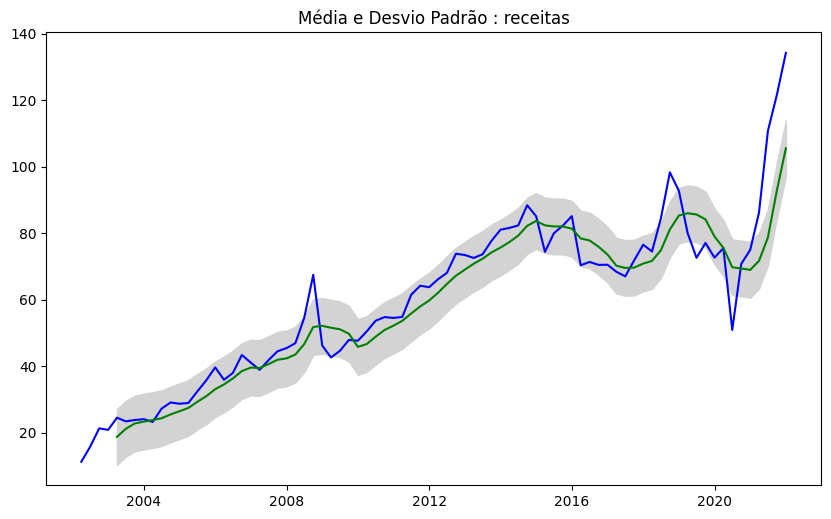

In [95]:
# Plotando 
moving_average.plot_train_test()
# Azul => Verdadeiro
# Verde => Média Móvel
# Cinza => Margem de erro

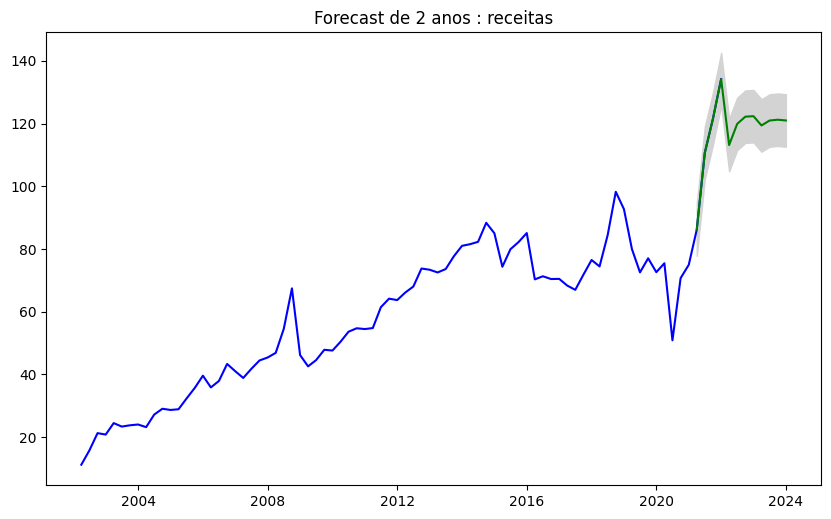

In [96]:
# Forecasting
# Prevendo 2 anos
# Azul => Valores Reais/Históricos até 2021
# Verde => Preditos após 2021
moving_average.forecast()
moving_average.plot_forecast()

#### Regressão Linear

In [97]:
# Regressão Linear
# FEATURES: São os 4 últimos valores
# Y: Valor atual
# Execução em janela:
#   Treina 12 trimestres, preve próximo trimestre

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

class Linear_model():

    name = 'Linear'

    def __init__(self):
        self.model = LinearRegression()
        self.mms = MinMaxScaler()

    def fit(self, x_train, y_train):
        X_train_mms = self.mms.fit_transform(x_train)
        self.model.fit(X_train_mms, y_train)

    def predict(self, x_test):
        X_test_mms = self.mms.transform(x_test)
        return self.model.predict(X_test_mms)

# Criar as features com base nos periodos anteriores
from past.builtins import xrange

def prepare_dataset(df, property, num_quarters=4):
    x = []
    y = []

    df_x = df[property]
    # FEATURES: São os 4 últimos valores
    for d in xrange(num_quarters,df_x.shape[0]):
        x.append(df_x.iloc[d-num_quarters:d].values.ravel())
        # Y: Valor atual
        y.append(df_x.iloc[d])
  
    return x, y

# Treinando e testando modelo utilizando periodos anteriores como features

def run_model(property):

    num_quarters = 4 # Quantos trimestres anteriores serão features
    num_quarters_train = 12 # Quantos trimestres de treino para 

    x, y = prepare_dataset(df, property, num_quarters)

    y_pred = []
    y_actual = []

    end = len(y)

    # Execução em janela:
    #   Treina 12 trimestres, preve próximo trimestre
    for i in range(num_quarters_train, end):

        start = i - num_quarters_train
        x_train = x[start:i]
        y_train = y[start:i]

        x_test = x[i]
        y_test = y[i]

        # Execução do modelo
        model = Linear_model()
        model.fit(x_train, y_train)
        predicted = model.predict(x_test.reshape(1, -1))
        y_pred.append(predicted[0])
        y_actual.append(y_test)
    return y_actual, y_pred

# Função plot

def plot_model_results(property, y_actual, y_pred):
    index = pd.date_range('2003', periods=len(y_actual), freq="Q-DEC")

    y_actual = pd.Series(y_actual, index)
    y_pred = pd.Series(y_pred, index)

    # Calculando Métricas
    mae, mse, rmse = mae_mse_rmse(y_actual, y_pred)
    print("Regressão Linear RMSE: ", rmse)

    # Plotando predito x real

    plt.title(f'Petrobras : {property}')
    pred_plot, = plt.plot(y_pred,color='blue',label='Predito')
    actual_plot, = plt.plot(y_actual,color='red', label='Real')

    plt.fill_between(index, 
                      y_pred + rmse,
                      y_pred - rmse, color="lightgray")

    plt.legend(handles=[actual_plot,pred_plot])
    plt.show()

    return rmse

Regressão Linear RMSE:  11.5326


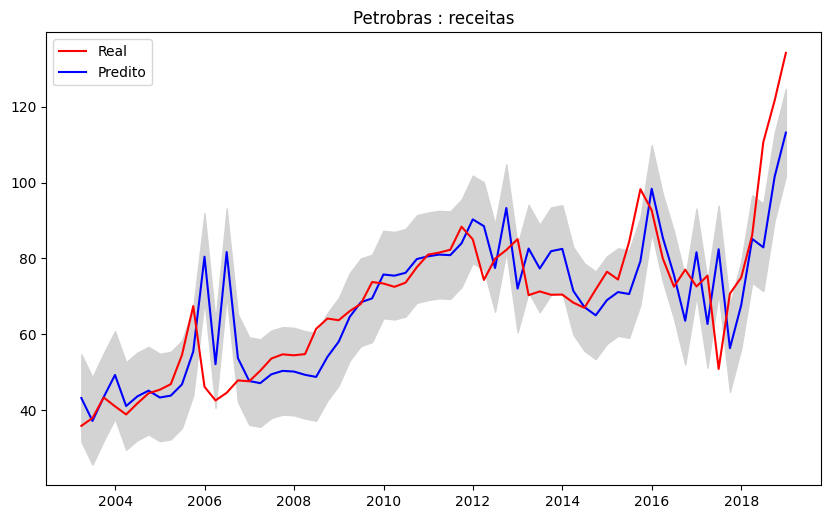

In [98]:
# Rodar modelo
y_actual, y_pred = run_model(property)
linear_rmse = plot_model_results(property, y_actual, y_pred)

In [99]:
# Função para prever próximos 2 anos

def linear_forecast(property, linear_rmse):
    num_forecasts = 8 # 2 anos * 4 trimestres
    num_quarters = 4


    # Modelo linear
    model = Linear_model()
    x_train, y_train = prepare_dataset(df, property)
    model.fit(x_train, y_train)

    series = pd.Series(df[property][-num_quarters:], index=df.index[-num_quarters:])

    for forecast in range(1, num_forecasts + 1):
        last_quarters = series[-num_quarters:].to_numpy()
        # Média dos ultimos trimestres
        linear_model_forecast = model.predict(last_quarters.reshape(1, -1))
        series = series.append(pd.Series(linear_model_forecast))

    # Refazer o index
    new_index = pd.date_range(series.index[-0], periods=num_forecasts + num_quarters, freq="Q-DEC")
    series.index = new_index
    linear_model_forecast = series

    # Plotando 
    plt.plot(df[property], color = "blue")
    plt.plot(linear_model_forecast, color="green")
    plt.plot(moving_average.forecast, color="orange")
    plt.fill_between(linear_model_forecast.index, 
                      linear_model_forecast + linear_rmse,
                      linear_model_forecast - linear_rmse, color="lightgray")
    plt.title(f"Forecast de {num_forecasts/4:n} anos")
    plt.show()
    return linear_model_forecast

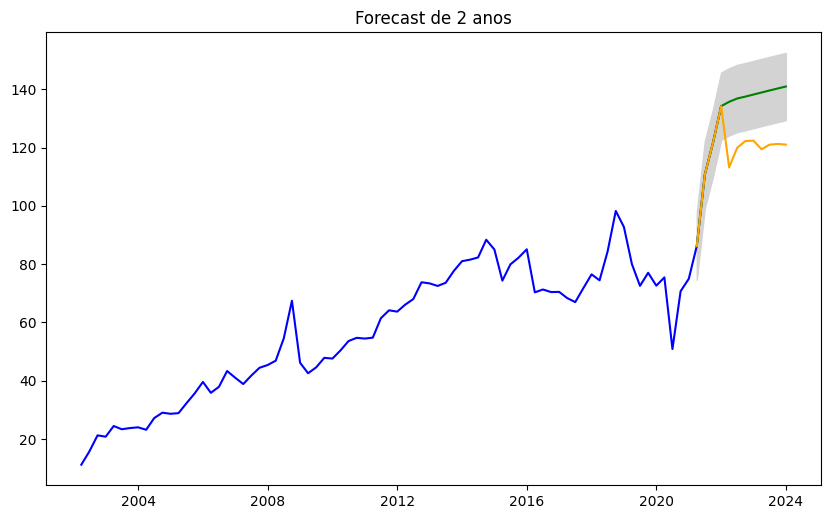

In [100]:
# Forecasting

linear_model_forecast = linear_forecast(property, linear_rmse)

#### SARIMA

In [101]:
# Modelo Sarima

# Buscar melhor hiperparametros para a serie temporal

class Sarima():

    def __init__(self, df, property, num_forecasts):
        self.df = df
        self.property = property
        self.num_forecasts = num_forecasts
        self.num_quarters = 4

    def best_hiperparams(self, execute=False):
        #p =>  Sazonalidade (Seasonality)
        #d =>  Tendência (Trend)
        #q =>  Ruído (Noise)
        self.pdq = (2, 2, 0)
        self.spdq = (2, 2, 0, 12)
        if execute is True:
            p = range(0, 3)
            d = range(0, 3)
            q = range(0, 3)
            pdq = list(itertools.product(p, d, q))
            seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

            lower_aic = 999999

            for param in pdq:
                for param_seasonal in seasonal_pdq:
                    try:
                        mod = sm.tsa.statespace.SARIMAX(self.df[self.property],
                                                        order=param,
                                                        seasonal_order=param_seasonal,
                                                        enforce_stationarity=False,
                                                        enforce_invertibility=False,
                                                        freq="Q-DEC")
                        results = mod.fit()
                        if results.aic < lower_aic:
                            lower_aic = results.aic
                            self.pdq = param
                            self.spdq = param_seasonal
                    except:
                        continue

    def fit(self):
        self.mod = sm.tsa.statespace.SARIMAX(self.df[self.property],
                                order=self.pdq,
                                seasonal_order=self.spdq,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
        self.results = self.mod.fit()

    def print_fit_results(self):
        print(self.results.summary().tables[1])

    def plot_fit_diagnostics(self):
        self.results.plot_diagnostics(figsize=(16, 8))
        plt.show()

    def train_test(self):
        # Prevendo dados a partir de 2015
        self.start_test_prediction = '2015-12-31'
        self.pred = self.results.get_prediction(start=pd.to_datetime(self.start_test_prediction), dynamic=False)
        self.pred_ci = self.pred.conf_int()

    def plot_train_test(self):
        ax = self.df[self.property].plot(label='Real')
        self.pred.predicted_mean.plot(ax=ax, label='Predito', alpha=.7, figsize=(14, 7), color="red")
        ax.fill_between(self.pred_ci.index,
                        self.pred_ci.iloc[:, 0],
                        self.pred_ci.iloc[:, 1], color='lightgray')
        ax.set_xlabel('Data')
        ax.set_ylabel(self.property)
        plt.legend()
        plt.show()

    def print_stats(self):
        self.mae, self.mse, self.rmse = mae_mse_rmse(self.df[self.property][self.start_test_prediction:], self.pred.predicted_mean)
        print("Receitas MAE Média Móvel", self.mae)
        print("Receias MSE Média Móvel", self.mse)
        print("Receias RMSE Média Móvel", self.rmse)

    def forecast(self):
        # Forecast de 2 anos
        self.pred_forecast = self.results.get_forecast(steps=self.num_forecasts)
        self.pred_forecast_ci = self.pred_forecast.conf_int()

    def plot_forecast(self, moving_average=None, linear_model_forecast=None):
        ax = self.df[self.property].plot(label='Real', figsize=(14, 7), title=f'Forecast {self.num_forecasts/4:n} anos: {property}')
        self.pred_forecast.predicted_mean.plot(ax=ax, label='SARIMA', color="red")
        if linear_model_forecast is not None:
            linear_model_forecast.plot(ax=ax, label='Regressão Linear', color="green")
        if moving_average is not None:
            moving_average.forecast.plot(ax=ax, label='Média Móvel', color="orange")
        ax.fill_between(self.pred_forecast_ci.index,
                        self.pred_forecast_ci.iloc[:, 0],
                        self.pred_forecast_ci.iloc[:, 1], color='lightgray')
        ax.set_xlabel('Data')
        ax.set_ylabel(self.property)
        plt.legend()
        plt.show()

In [102]:
# Modelo Sarima

sarima_model = Sarima(df, property, num_forecasts)
sarima_model.best_hiperparams()

In [103]:
# Fit do modelo
sarima_model.fit()
sarima_model.print_fit_results()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1549      0.190     -6.080      0.000      -1.527      -0.783
ar.L2         -0.3844      0.182     -2.116      0.034      -0.741      -0.028
ar.S.L12      -0.8529      0.194     -4.388      0.000      -1.234      -0.472
ar.S.L24      -0.2947      0.151     -1.957      0.050      -0.590       0.000
sigma2        60.3266     20.519      2.940      0.003      20.110     100.543


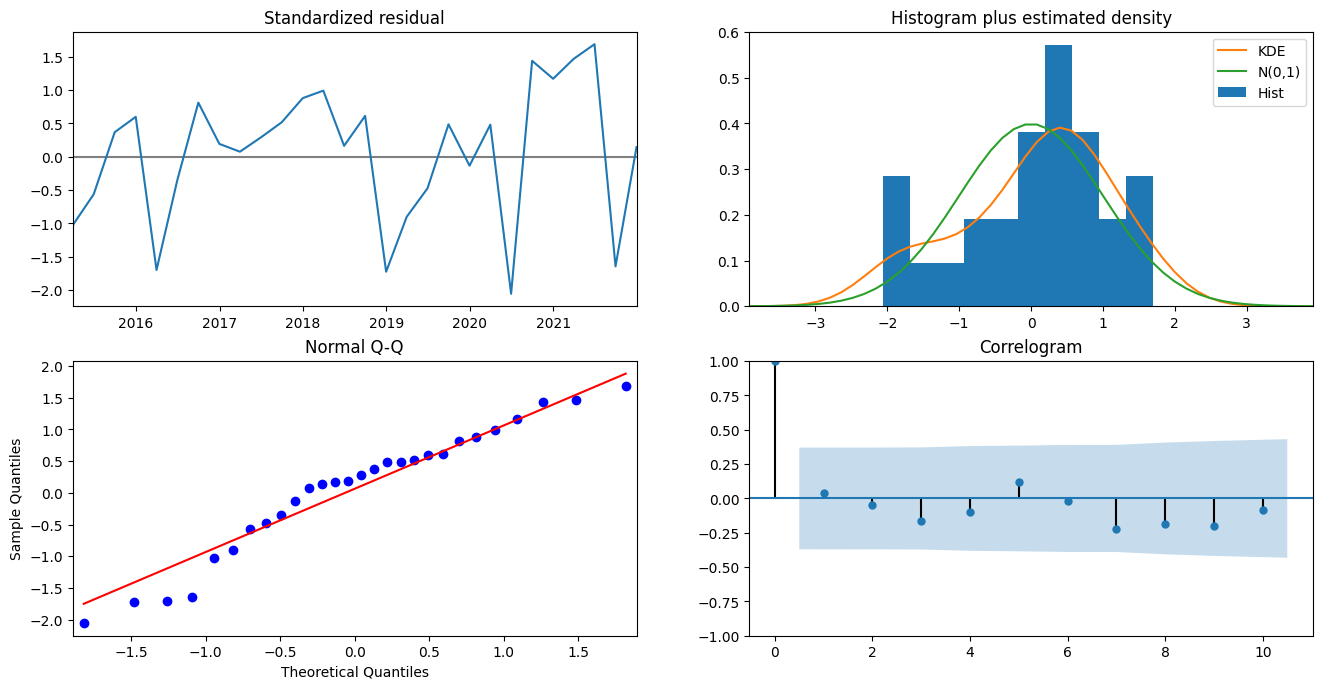

In [104]:
# Diagnosticos
sarima_model.plot_fit_diagnostics()

In [105]:
# Treino
sarima_model.train_test()
sarima_model.print_stats()

Receitas MAE Média Móvel 6.5264
Receias MSE Média Móvel 63.9447
Receias RMSE Média Móvel 7.9965


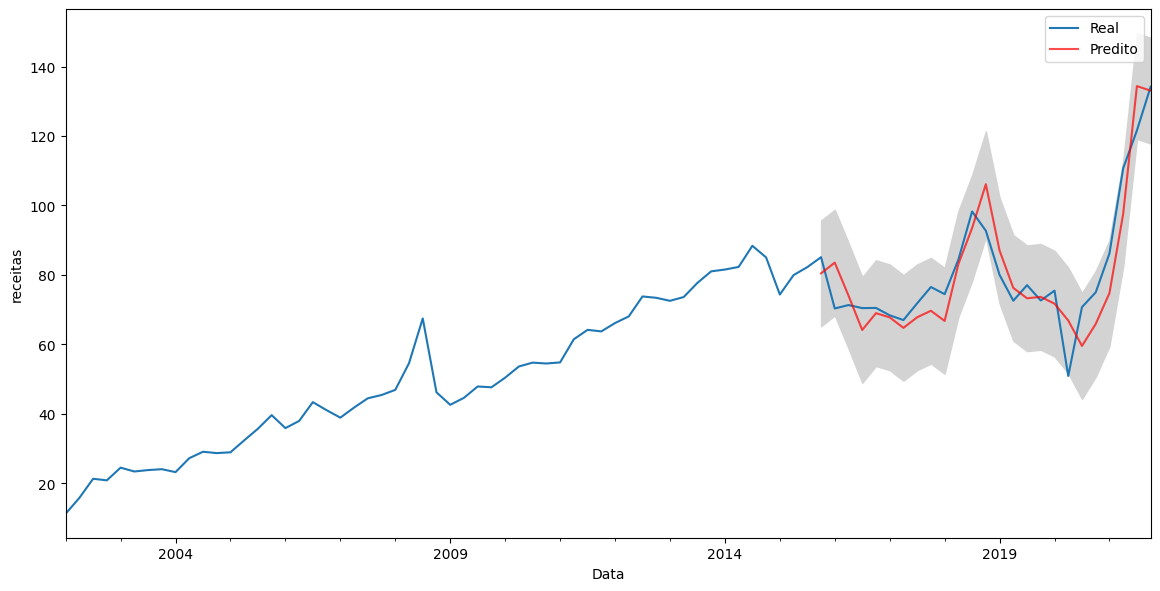

In [106]:
# Plot do Treino
sarima_model.plot_train_test()

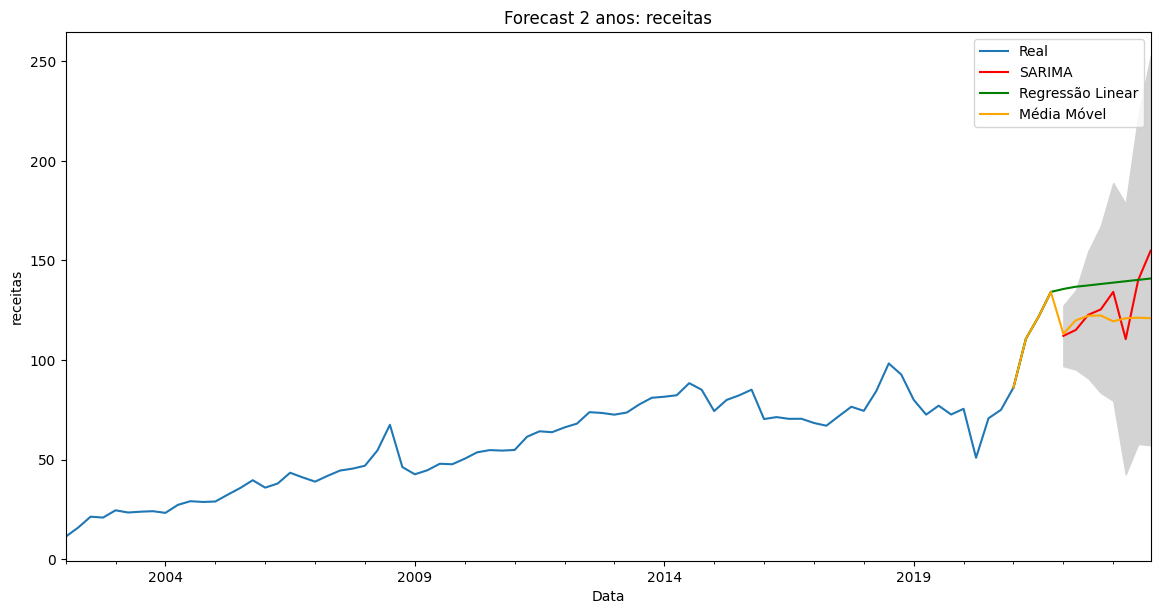

In [107]:
# Forecasting
sarima_model.forecast()
sarima_model.plot_forecast(moving_average, linear_model_forecast)

## Simulação/Otimização no valor do Forecast

* Conseguir simular/otimizar um valor do futuro
  * Meu forecast aponta que o Lucro será X, o que eu deveria fazer para o Lucro ser X + 25%?

In [108]:
# Busca do melhor parametro para cada serie temporal
# Demora para executar, então executei uma vez e deixei salvo na celula debaixo

# columns = ['receitas','custos', 'despesas_receitas_operacionais','resultado_financeiro','impostos','resultado_liquido_descontinuadas','participacoes_outras_empresas']

# for column in columns:
    # sarima_model = Sarima(df, column, num_forecasts)
    # sarima_model.best_hiperparams(True)
    # print("COLUMN", column)
    # print("PDQ", sarima_model.pdq)
    # print("SPDQ", sarima_model.spdq)

# COLUMN receitasPDQ (2, 2, 0)SPDQ (2, 2, 0, 12)
# COLUMN custosPDQ (2, 2, 0)SPDQ (2, 2, 0, 12)
# COLUMN despesas_receitas_operacionaisPDQ (2, 1, 1)SPDQ (2, 2, 0, 12)
# COLUMN resultado_financeiroPDQ (2, 2, 1)SPDQ (2, 2, 0, 12)
# COLUMN impostosPDQ (2, 2, 2)SPDQ (2, 2, 0, 12)
# COLUMN resultado_liquido_descontinuadasPDQ (2, 1, 1)SPDQ (2, 2, 0, 12)
# COLUMN participacoes_outras_empresasPDQ (1, 1, 2)SPDQ (2, 2, 1, 12)

In [109]:
# Hiperparametros de cada coluna

columns = [
          ['receitas', (2, 2, 0), (2, 2, 0, 12) ],
          ['custos', (2, 2, 0), (2, 2, 0, 12)],
          ['despesas_receitas_operacionais',(2, 1, 1), (2, 2, 0, 12)],
          ['resultado_financeiro',(2, 2, 1), (2, 2, 0, 12)],
          ['impostos',(2, 2, 2), (2, 2, 0, 12)],
          ['resultado_liquido_descontinuadas',(2, 1, 1), (2, 2, 0, 12)],
          ['participacoes_outras_empresas', (1, 1, 2), (2, 2, 1, 12)]
]

# Forecast que vamos otimizar
forecast_quarter_simul = '2022-Q1'
columns_result = []
columns_forecast = []

# Rodando para cada coluna o modelo Sarima, com seus hiperparametros
for column in columns:
    sarima_model = Sarima(df, column[0], num_forecasts)
    sarima_model.pdq = column[1]
    sarima_model.spdq = column[2]
    # sarima_model.best_hiperparams(True) 
    sarima_model.fit()
    sarima_model.train_test()
    sarima_model.forecast()

    # Armazenando forecast de cada coluna
    sarima_forecast = sarima_model.pred_forecast.predicted_mean
    columns_forecast.append(sarima_forecast)

    # Armazenando forecast do trimestre a ser otimizado
    columns_result.append(sarima_forecast[forecast_quarter_simul])

# Variaveis
receitas = columns_result[0]
custos = columns_result[1]
despesas_receitas_operacionais = columns_result[2]
resultado_financeiro = columns_result[3]
impostos = columns_result[4]
resultado_liquido_descontinuadas = columns_result[5]
participacoes_outras_empresas = columns_result[6]

In [110]:
# Calcular o lucro_periodo através das fórmulas com o forecast de cada coluna

lucro_periodo_forecast = []

for idx in range(0, num_forecasts):
    n = 7
    x0 = np.zeros(n)
    x0[0] = columns_forecast[0][idx] # receitas
    x0[1] = columns_forecast[1][idx] # custos
    x0[2] = columns_forecast[2][idx] # despesas_receitas_operacionais
    x0[3] = columns_forecast[3][idx] # resultado_financeiro
    x0[4] = columns_forecast[4][idx] # impostos
    x0[5] = columns_forecast[5][idx] # resultado_liquido_descontinuadas
    x0[6] = columns_forecast[6][idx] # participacoes_outras_empresas

    x0_lucro_liq = lucro_liq(x0)

    lucro_periodo_forecast.append(x0_lucro_liq)

lucro_periodo_forecast = pd.Series(lucro_periodo_forecast, index=columns_forecast[0].index)
lucro_periodo_forecast

2022-03-31     10.301069
2022-06-30     14.690867
2022-09-30     38.256369
2022-12-31     10.862218
2023-03-31    -17.713190
2023-06-30    -32.659619
2023-09-30    -71.363826
2023-12-31   -157.518595
Freq: Q-DEC, dtype: float64

In [111]:
# Executar otimização com periodo 2022-Q1

# Função auxiliar para calcular percentuais
def perc(a, b):
    return abs(round(a / b * 100, 0))

# Definir parametros
n = 7
x0 = np.zeros(n)
x0[0] = receitas
x0[1] = custos
x0[2] = despesas_receitas_operacionais
x0[3] = resultado_financeiro
x0[4] = impostos
x0[5] = resultado_liquido_descontinuadas
x0[6] = participacoes_outras_empresas

# Objetivo: Aumentar em 25% o Lucro Líquido
x0_lucro_liq = lucro_liq(x0)
goal = lucro_liq(x0) * (1.25 if x0_lucro_liq > 0 else 0.75)

# Executar a otimização
solution = optimize(x0, goal)

# Valor objetivo encontrado
solution_res = solution.fun 

# Parametros usados para encontrar o valor objetivo
params = solution.x

print("Goal                       : ", goal)
print("Otimização alcançou o valor: ", solution_res)
print("Número de simulações       : ", solution.nit)
print("")

result_table = [
    ['receitas',                             params[0],    perc(params[0], params[0]),    x0[0],        perc(x0[0], x0[0]),        perc(params[0], x0[0])],
    ['custos',                               params[1],    perc(params[1], params[0]),    x0[1],        perc(x0[1], x0[0]),        perc(params[1], x0[1])],
    ['despesas_receitas_operacionais',       params[2],    perc(params[2], params[0]),    x0[2],        perc(x0[2], x0[0]),        perc(params[2], x0[2])],
    ['resultado_financeiro',                 params[3],    perc(params[3], params[0]),    x0[3],        perc(x0[3], x0[0]),        perc(params[3], x0[3])],
    ['impostos',                             params[4],    perc(params[4], params[0]),    x0[4],        perc(x0[4], x0[0]),        perc(params[4], x0[4])],
    ['resultado_liquido_descontinuadas',     params[5],    perc(params[5], params[0]),    x0[5],        perc(x0[5], x0[0]),        perc(params[5], x0[5])],
    ['participacoes_outras_empresas',        params[6],    perc(params[6], params[0]),    x0[6],        perc(x0[6], x0[0]),        perc(params[6], x0[6])],
    ['Lucro líquido',                        solution_res, perc(solution_res, params[0]), x0_lucro_liq, perc(solution_res, x0[0]), perc(solution_res, x0_lucro_liq)]
]

print(tabulate(result_table, headers=['Linha DRE', 'Valor Otimizado', "% A.V*", "Valor Inicial", "% A.V*", "% (Otimizado / Inicial)"]))
print("")
print("*Análise vertical => Essa análise acontece de cima para baixo ou de baixo para cima, indicando resultados em efeito cascata, ele é utilizado para identificar a porcentagem de participação de determinado indicador no resultados. ")

Goal                       :  12.876336579876291
Otimização alcançou o valor:  12.87633657987629
Número de simulações       :  2

Linha DRE                           Valor Otimizado    % A.V*    Valor Inicial    % A.V*    % (Otimizado / Inicial)
--------------------------------  -----------------  --------  ---------------  --------  -------------------------
receitas                                112.622           100      112.115           100                        100
custos                                  -59.5222           53      -60.0288           54                         99
despesas_receitas_operacionais          -11.3189           10      -11.8255           11                         96
resultado_financeiro                    -23.37             21      -23.8766           21                         98
impostos                                 -5.74252           5       -6.24908           6                         92
resultado_liquido_descontinuadas          0.236065        

In [112]:
forecast_simul_solution = {
    'date': pd.Period(forecast_quarter_simul, 'Q-DEC'),
    'receitas' : params[0],
    'custos' : params[1],
    'despesas_receitas_operacionais' : params[2],
    'resultado_financeiro' : params[3],
    'impostos' : params[4],
    'resultado_liquido_descontinuadas' : params[5],
    'participacoes_outras_empresas' : params[6],
    'lucro_periodo': solution_res
}
forecast_simul_solution

{'custos': -59.522205938775144,
 'date': Period('2022Q1', 'Q-DEC'),
 'despesas_receitas_operacionais': -11.318944740816917,
 'impostos': -5.742515934904965,
 'lucro_periodo': 12.87633657987629,
 'participacoes_outras_empresas': -0.027829500450837426,
 'receitas': 112.62179726111779,
 'resultado_financeiro': -23.370029531479528,
 'resultado_liquido_descontinuadas': 0.23606496518588926}

In [113]:
# Modelo Sarima com lucro_periodo

sarima_model = Sarima(df, 'lucro_periodo', num_forecasts)
sarima_model.best_hiperparams()
sarima_model.fit()
sarima_model.train_test()
sarima_model.forecast()

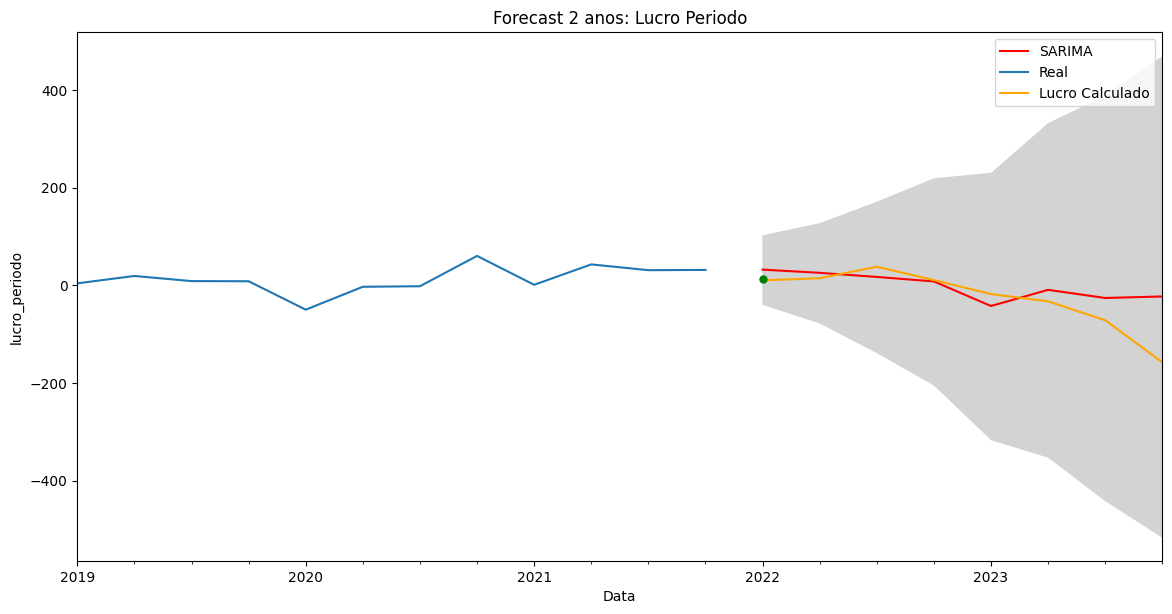

In [114]:
# Plotando forecast do lucro_periodo e com o lucro_periodo calculado através do forecast das variaveis
# Em verde, plotando o valor otimizado

ax = sarima_model.pred_forecast.predicted_mean.plot(label='SARIMA', color="red", figsize=(14, 7))
sarima_model.df[sarima_model.property]['2019':].plot(ax=ax, label='Real')
lucro_periodo_forecast.plot(ax=ax, label="Lucro Calculado", color="orange")

ax.fill_between(sarima_model.pred_forecast_ci.index,
                sarima_model.pred_forecast_ci.iloc[:, 0],
                sarima_model.pred_forecast_ci.iloc[:, 1], color='lightgray')

# Plotando lucro do periodo otimizado
plt.plot(forecast_simul_solution['date'], forecast_simul_solution['lucro_periodo'], marker="o", markersize=5, markeredgecolor="green", markerfacecolor="green")

ax.set_xlabel('Data')
ax.set_ylabel(sarima_model.property)
ax.set_title(f'Forecast {sarima_model.num_forecasts/4:n} anos: Lucro Periodo')
plt.legend()
plt.show()